# Demonstration of the Gaussian density kernel algorithm 

## Table of Content <a name="TOC"></a>

1. [General setups](#setups)
2. [Examples](#examples)
  
  2.1. [Detailed example of convergence, ordered pre-defined data](#example1)
  
  2.2. [Short workflow, ordered pre-defined data](#example2)
  
  2.3. [Short workflow, disordered pre-defined data](#example3)
  
  2.4. [Short workflow, disordered random data](#example4)  

## A. Learning objectives

- to be able to approximate the probability density of randomly distributed points by a superposition of Gaussian functions
- to be able to determine the "best" parameters of all the Gaussians in such approximation


## B. Use cases

- [computing the probability distribution of random points](#fit-prob-dens-ex1) | [Example 2](#fit-prob-dens-ex2)


## C. Functions
   
- `libra_py`
  - `data_visualize`
   - [`colors`](#colors)      
  - `gaussian_kernel_algorithm`
   - [`compute_apriory_prob_densities_1D`](#compute_apriory_prob_densities_1D)   
   - [`compute_widths_1D`](#compute_widths_1D)
   - [`gaussian_density_estimator_1D`](#gaussian_density_estimator_1D)
   - [`gaussian_kernel_algorithm_iteration_1D`](#gaussian_kernel_algorithm_iteration_1D)

   
## D. Classes and class members
    
- `liblibra::librandom`
  - [`Random`](#random)
   - [`normal`](#normal)
   

## 1. General setups
<a name="setups"></a>[Back to TOC](#TOC)

The problem that we try solving in this tutorial is the following.

Imagine you have N (large number) of multidimensional points (which can be understood as configuration points of the molecules on the configuration space). For 1D or 2D distributions, it should be pretty straightforward to tell by the naked eye what is the distribution of the points: you can spot the corresponding peaks and dips in the distribution function, which would correspond to excessive accumulations or sparsifying of the data points. 

However, what if you need to determine an analytical function that would descrbe such an empirical probability distribution? A very logical approach is to introduce the probability density kernels - the functions, whose combination would yield the observed density. Such choices could be pretty flexible, but something that appears to be quite reasonable is to use just Gaussian functions:

$$
K(X) = (2\pi)^{-\frac{N_{dof}}{2}} exp(-\frac{1}{2} X^T X)
$$

Here $X$ is a multidimensional point, of the dimensionality $N_{dof}$.

Then, the observed ("target") probability density density, $P_{empirical}( X; \{Q\} )$ can be approximated as:

$$
P_{empirical}( X; \{Q\} ) \approx \frac{1}{M} \sum_{i=0}^{M} \frac{1}{h_i} K(\frac{X - Q_i}{h_i} )
$$

In these formulas, $\{Q\}$ refers to the entire set of input data points (whose distribution we are looking to approximate), $X$ is the variable.

This problem appears in some formulations of Bohmian dynamics, where one needs to define an analytical function representing the probability density of a swarm of "classical" trajectories. The solution (the Gaussian kernel algorithm) is discussed in [this reference](https://arxiv.org/abs/1712.01918). This is what we demonstrate in this tutorial.

Lets import all the modules that we need. Most of the stuf for the Gaussian kernel algorithm is defined in the module `libra_py.gaussian_kernel_algorithm`. 

We also import some color definitions from the `libra_py.data_visualize` module.

In [1]:
import sys
import math
import os
import numpy as np
import matplotlib.pyplot as plt   # plots

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *

import libra_py.data_visualize as datvis
import libra_py.gaussian_kernel_algorithm as gka

%matplotlib inline 

/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<float, std::all

Define an auxiliary function to generate the equdistantly spaces points of the grid

In [2]:
def make_grid(xmin, xmax, dx):
    """
    
    """
    npts = int((xmax-xmin)/dx) + 1
    
    res = []
    for i in range(npts):
        res.append(xmin + dx * i)
    
    return res

The following auxiliary function evaluates the empirical Gaussian density (according to the second equation in the intro secstion). The evaluation is done at every point of the input grid `x_grid`. The evaluation assumes we know the positions of the Gaussian centers, `q`, and the corresponding Gaussian widths parameters, `h`. 

Note that the parameters `h` are the subjects to iterative optimization - something the algorithm can do.
<a name="gaussian_density_estimator_1D"></a>

In [3]:
def compute_fitted_prob_densities_1D(x_grid, q, h):
    """
    x_grid (list of doubles): grid points
    q (list of doubles): the centers of the worlds
    h (list of doubles): band width parameters     
    """
    
    npts = len(x_grid)
    val = []
    
    for ipt in range(npts):
        val.append( gka.gaussian_density_estimator_1D(x_grid[ipt], q, h))

    return val

New, we define a convenience function, which would plot the first input data set as scatter points - these should be the original data (e.g. so-called empirical probability density values - something we aim to reproduce with the smoothened Gaussian kernel function). The rest of the data are lines, and usually they correspond to the probability densities recomputed with the optimized width parameters.
<a name="colors"></a>

In [4]:
def plot_my_res(ax, xgrid, prob, labels, clrs):
    """
    """
    
    ax.rc('axes', titlesize=28)      # fontsize of the axes title
    ax.rc('axes', labelsize=28)      # fontsize of the x and y labels
    ax.rc('legend', fontsize=24)     # legend fontsize
    ax.rc('xtick', labelsize=20)    # fontsize of the tick labels
    ax.rc('ytick', labelsize=20)    # fontsize of the tick labels

    ax.rc('figure.subplot', left=0.2)
    ax.rc('figure.subplot', right=0.95)
    ax.rc('figure.subplot', bottom=0.13)
    ax.rc('figure.subplot', top=0.88)


    ax.figure(1, figsize=(12, 12), dpi=300, frameon=False)
    ax.subplot(1,1,1)
    ax.title('Gaussian kernel algorithm')
    ax.xlabel('Coordinate, a.u.')
    ax.ylabel('Probability density')
    
    nsets = len(xgrid) 
    for iset in range(nsets):
        if iset==0:            
            ax.scatter(xgrid[iset], prob[iset], s=100, c='b', marker='o', label=labels[iset] ) 
        else:
            ax.plot(xgrid[iset], prob[iset] , label=labels[iset], linewidth=5, \
                     color = datvis.colors[ clrs[iset] ] )             
    
    ax.legend()    
    ax.show()
    ax.close()    

## 2. Examples
<a name="examples"></a>[Back to TOC](#TOC)

Next, lets consider several situations of input parameters and how to compute the desired properties

### 2.1. Example 1: Detailed example of convergence, ordered pre-defined data
<a name="example1"></a>[Back to TOC](#TOC)

A typical workflow of computations would be the folowing:

1. Using the coordinates of the original points (e.g. trajectories), compute the so-called apriori probability density - the one that we'll next take for the reference values of the population densities.

   A common practice for computing the apriori densities is to subdivide the space into "cells", e.g. via [Voronoi tessellation](https://en.wikipedia.org/wiki/Voronoi_diagram) and then the probability density for each point would be simply $P_i = \frac{1}{V_i}$ , where $V$ is the volume of the corresponding Voronoi cell.   

   The current implementation is limited to just 1D points, in which case the Voronoi tessellation is particularly simple: the boundaries for each cell lie at the mid-point of the nearby cells. This is done with the function `compute_apriory_prob_densities_1D` <a name="compute_apriory_prob_densities_1D"></a>
   
   Keep in mind, that before such tessellation is done, one would need to sort the datapoints. Of course, the input to the `compute_apriory_prob_densities_1D` function doesn't have to be ordered. However, for this first example, we provide the input data points in an already ordered fashion.
<a name="fit-prob-dens-ex1"></a>

In [5]:
# Apriory densities:
Q = [-1.0, -0.75, -0.5, -0.25, 0.0, 0.5, 1.0]
target_dens = gka.compute_apriory_prob_densities_1D(Q)

print(target_dens)

[0.5, 0.5, 0.5, 0.5, 0.3333333333333333, 0.25, 0.25]


2. Start with a guess smooth approximation for the probability density - the form in Eq. 2, but the widths of all Gaussians are arbitrary.

   With the help of the auxiliary functions `make_grid` and `compute_fitted_prob_densities_1D` defined above, we can compute the predicted probability densities along a 1D grid. 
   
   The `compute_fitted_prob_densities_1D` utilizes the `gaussian_density_estimator_1D` function from the `libra_py.gaussian_kernel_algorithm` module, as explained [above](#gaussian_density_estimator_1D)

In [6]:
# Make a finer grid
x_fine = make_grid(-2.0, 2.0, 0.1)
print("Grid points: ", x_fine)

# Guess widths:
h0 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
val0 = compute_fitted_prob_densities_1D(x_fine, Q, h0)

print("Values of the approximated probability density at the grid points:", val0)

Grid points:  [-2.0, -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.2999999999999998, -1.2, -1.1, -1.0, -0.8999999999999999, -0.7999999999999998, -0.7, -0.5999999999999999, -0.5, -0.3999999999999999, -0.2999999999999998, -0.19999999999999996, -0.09999999999999987, 0.0, 0.10000000000000009, 0.20000000000000018, 0.30000000000000027, 0.40000000000000036, 0.5, 0.6000000000000001, 0.7000000000000002, 0.8000000000000003, 0.9000000000000004, 1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 1.4000000000000004, 1.5, 1.6, 1.7000000000000002, 1.8000000000000003, 1.9000000000000004, 2.0]
Values of the approximated probability density at the grid points: [0.1023379771170376, 0.11685382661539258, 0.13230627625942631, 0.1485534594717235, 0.16541891332726208, 0.18269420449998822, 0.2001431184707474, 0.21750730743084667, 0.2345131959256265, 0.25087985587273987, 0.26632749183165844, 0.2805861298093307, 0.2934040830943303, 0.3045557788170362, 0.31384856860128113, 0.3211282125315379, 0.32628281200449455, 0.32924

However, the computed probability densities aren't bound to be a good approximation to the empirical distribution, since the parameters are not optimized. So, we:

3. Do several iteration of the width parameters as explined in [this reference](https://arxiv.org/abs/1712.01918) to optimize the parameters and improve the fitting.

   The approach take in the paper to update the parameters is simply:
   
   $$h_i \leftarrow h_i \frac{P_h(Q_i; \{Q\})}{p_i}$$
   
   This is done using function `gaussian_kernel_algorithm_iteration_1D`. 
   <a name="gaussian_kernel_algorithm_iteration_1D"></a> The function takes the input parameters `h` (in this example `h5` and `h10` variables) and modifies them directly. We store initial guess parameters and the optimized (to different degree) variables in separate variables and use them to recompute the analytical probability densities (in variables `val5` and `val10`). 
   
   Basically, we do a couple cycles with 5 iterations of the above procedure in each cycle, to eventually see how the procedure changes the fitting.   

In [7]:
# Improve the parameters
h5 = list(h0)
for i in range(5):
    gka.gaussian_kernel_algorithm_iteration_1D(Q, h5, target_dens)
val5 = compute_fitted_prob_densities_1D(x_fine, Q, h5)

print("Parameters optimized after 5 iterations: ", h5)
print("Analytical probability density aproximation on the grid after 5 iterations: ", val5)

# Improve more
h10 = list(h5)
for i in range(5):
    gka.gaussian_kernel_algorithm_iteration_1D(Q, h10, target_dens)
val10 = compute_fitted_prob_densities_1D(x_fine, Q, h10)

print("Parameters optimized after 10 iterations: ", h10)
print("Analytical probability density aproximation on the grid after 5 iterations: ", val10)

Parameters optimized after 5 iterations:  [0.24805229425352915, 0.45066203198249133, 0.4487581701900384, 0.3087216308700255, 1.040144827478121, 0.7430953372829212, 0.36441115875844704]
Analytical probability density aproximation on the grid after 5 iterations:  [0.012138763278384642, 0.016919230389786637, 0.024453738131132153, 0.03692332560473975, 0.05818662361782313, 0.09386760954993226, 0.14954012228896363, 0.22628833849225355, 0.3158238295993582, 0.40036158190983556, 0.4606216137701093, 0.48764256446438947, 0.4883796131891192, 0.4795720486246315, 0.4752664679331512, 0.4784114406867773, 0.4816164573345331, 0.4740859309244198, 0.44877941200213506, 0.40596947420900564, 0.35257261291143377, 0.298702959464071, 0.25367419100510175, 0.22330678526966508, 0.20920664442167794, 0.20947997811888414, 0.21991034517748198, 0.2349921241798663, 0.24880508228934659, 0.255961479946683, 0.25266173051085866, 0.23755937355369078, 0.21201576371321895, 0.1795419379994754, 0.14462114424354325, 0.11140044533

4. Finally, lets use the `plot_my_res` function defined above to plot all the data together:

  - the reference probability densities at given points (scatters);
  - the initial fit;
  - the fits with two degreees of optimization applied to the initial parameters

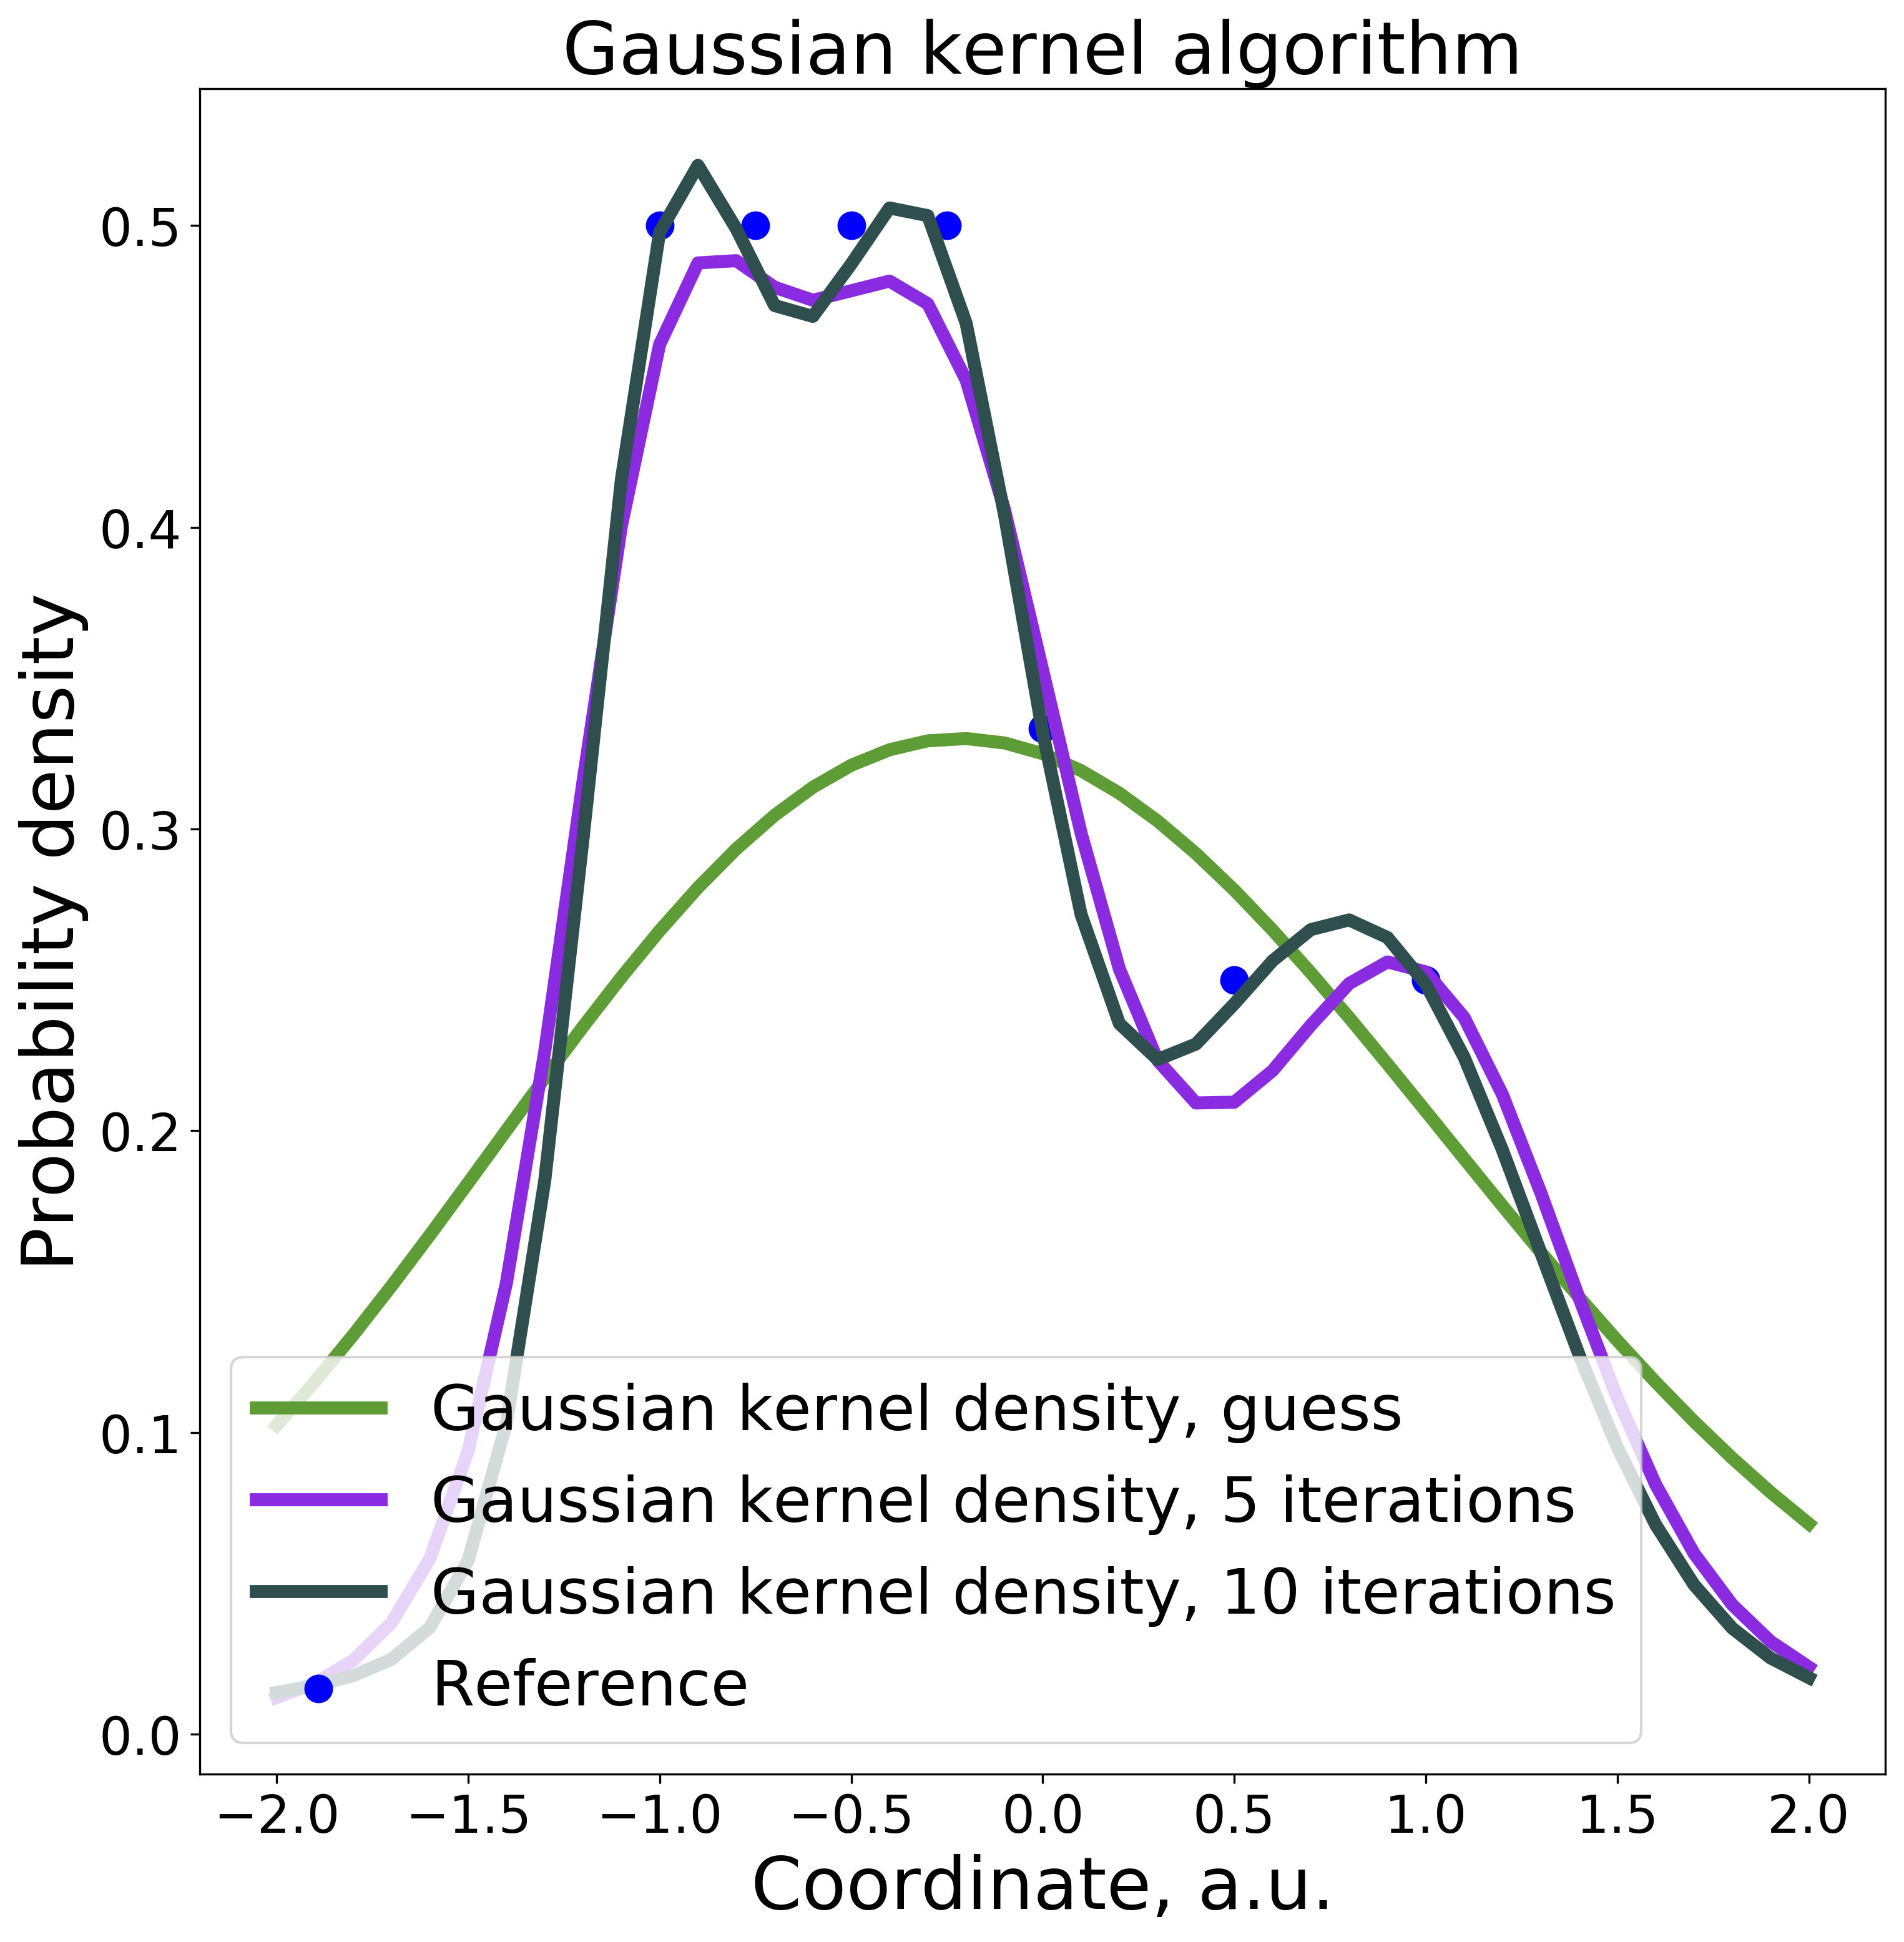

In [8]:
plot_my_res(plt, [Q, x_fine, x_fine, x_fine], 
                 [target_dens, val0, val5, val10], 
                 ["Reference", "Gaussian kernel density, guess", 
                  "Gaussian kernel density, 5 iterations", 
                  "Gaussian kernel density, 10 iterations"
                 ],
                 ["11", "21", "31", "41"]
           )

### 2.2. Example 2: Short workflow, ordered pre-defined data
<a name="example2"></a>[Back to TOC](#TOC)

In this example, we are going to repeat the above procedure of finding optimal Gaussian width parameters, but in a shorter way. This all is done with the help of `compute_width_1D` function. 

The function takes 3 parameters:
* first (`Q`) - the coordinates of the data points;
* second (`10`) - the number of iterations to make;
* third (`1.0`) - the initial value of the width parameters (same for all degrees of freedom);

Then we use the resulting parameters to compute the smooth function and plot all the data together.
<a name="compute_widths_1D"></a><a name="fit-prob-dens-ex2"></a>

[0.2044375183109118, 0.3598688179212191, 0.35435091672324176, 0.24695024813610145, 1.3011517240458799, 0.43131235569535464, 0.3838047666592906]


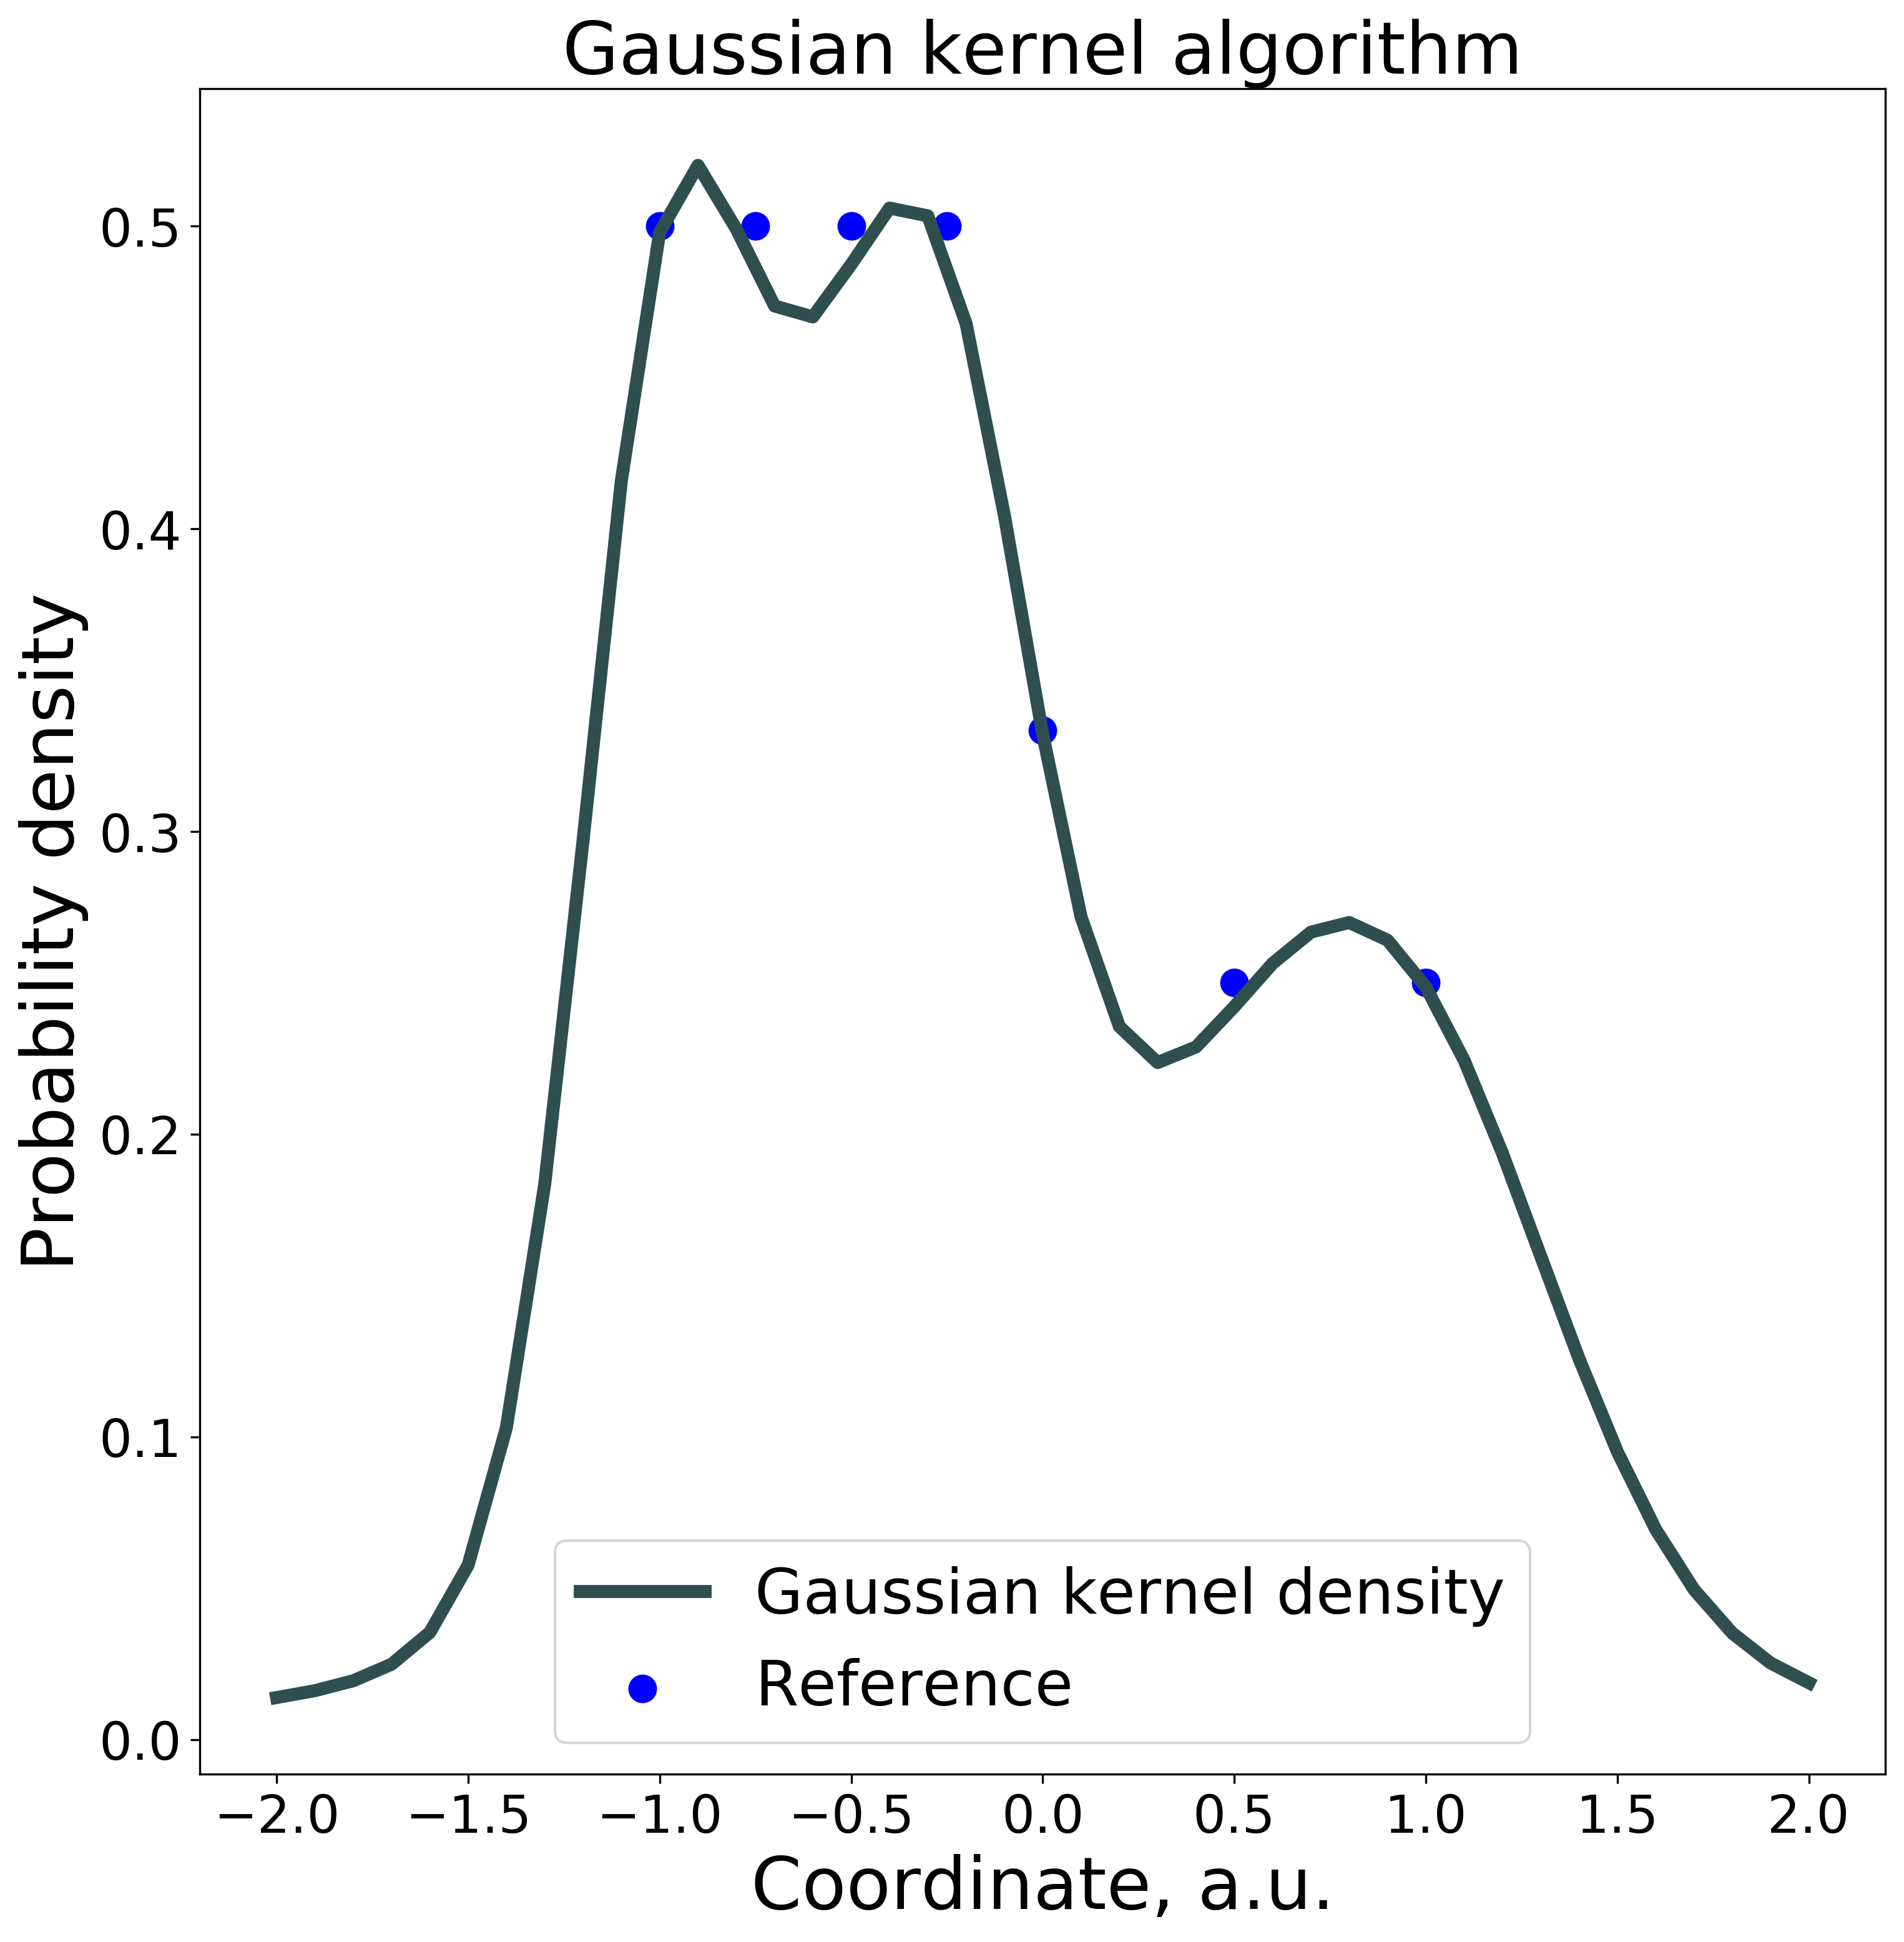

In [9]:
# Our data
Q = [-1.0, -0.75, -0.5, -0.25, 0.0, 0.5, 1.0]

# Compute the optimized widths
h_new = gka.compute_widths_1D(Q, 10, 1.0)
print(h_new)

# Compute the smooth function on the grid
x_fine = make_grid(-2.0, 2.0, 0.1)
val_new = compute_fitted_prob_densities_1D(x_fine, Q, h_new)

# Compute just for the plotting
target_dens = gka.compute_apriory_prob_densities_1D(Q)

# Plot all the results
plot_my_res(plt, [Q, x_fine], [target_dens, val_new], ["Reference", "Gaussian kernel density"], ["11", "41"])

### 2.3. Example 3: Short workflow, disordered pre-defined data
<a name="example3"></a>[Back to TOC](#TOC)

In this example, we show that the algorithm works as expected even if the input data are disordered. 

Everything is the same as in the example above, except for the input data

[0.19282282680711108, 0.33875291944686037, 0.06061799602306925, 1.003349587651797, 0.1311159031733688, 0.24256043060859936, 0.06552855386433239, 0.34271393399875477]


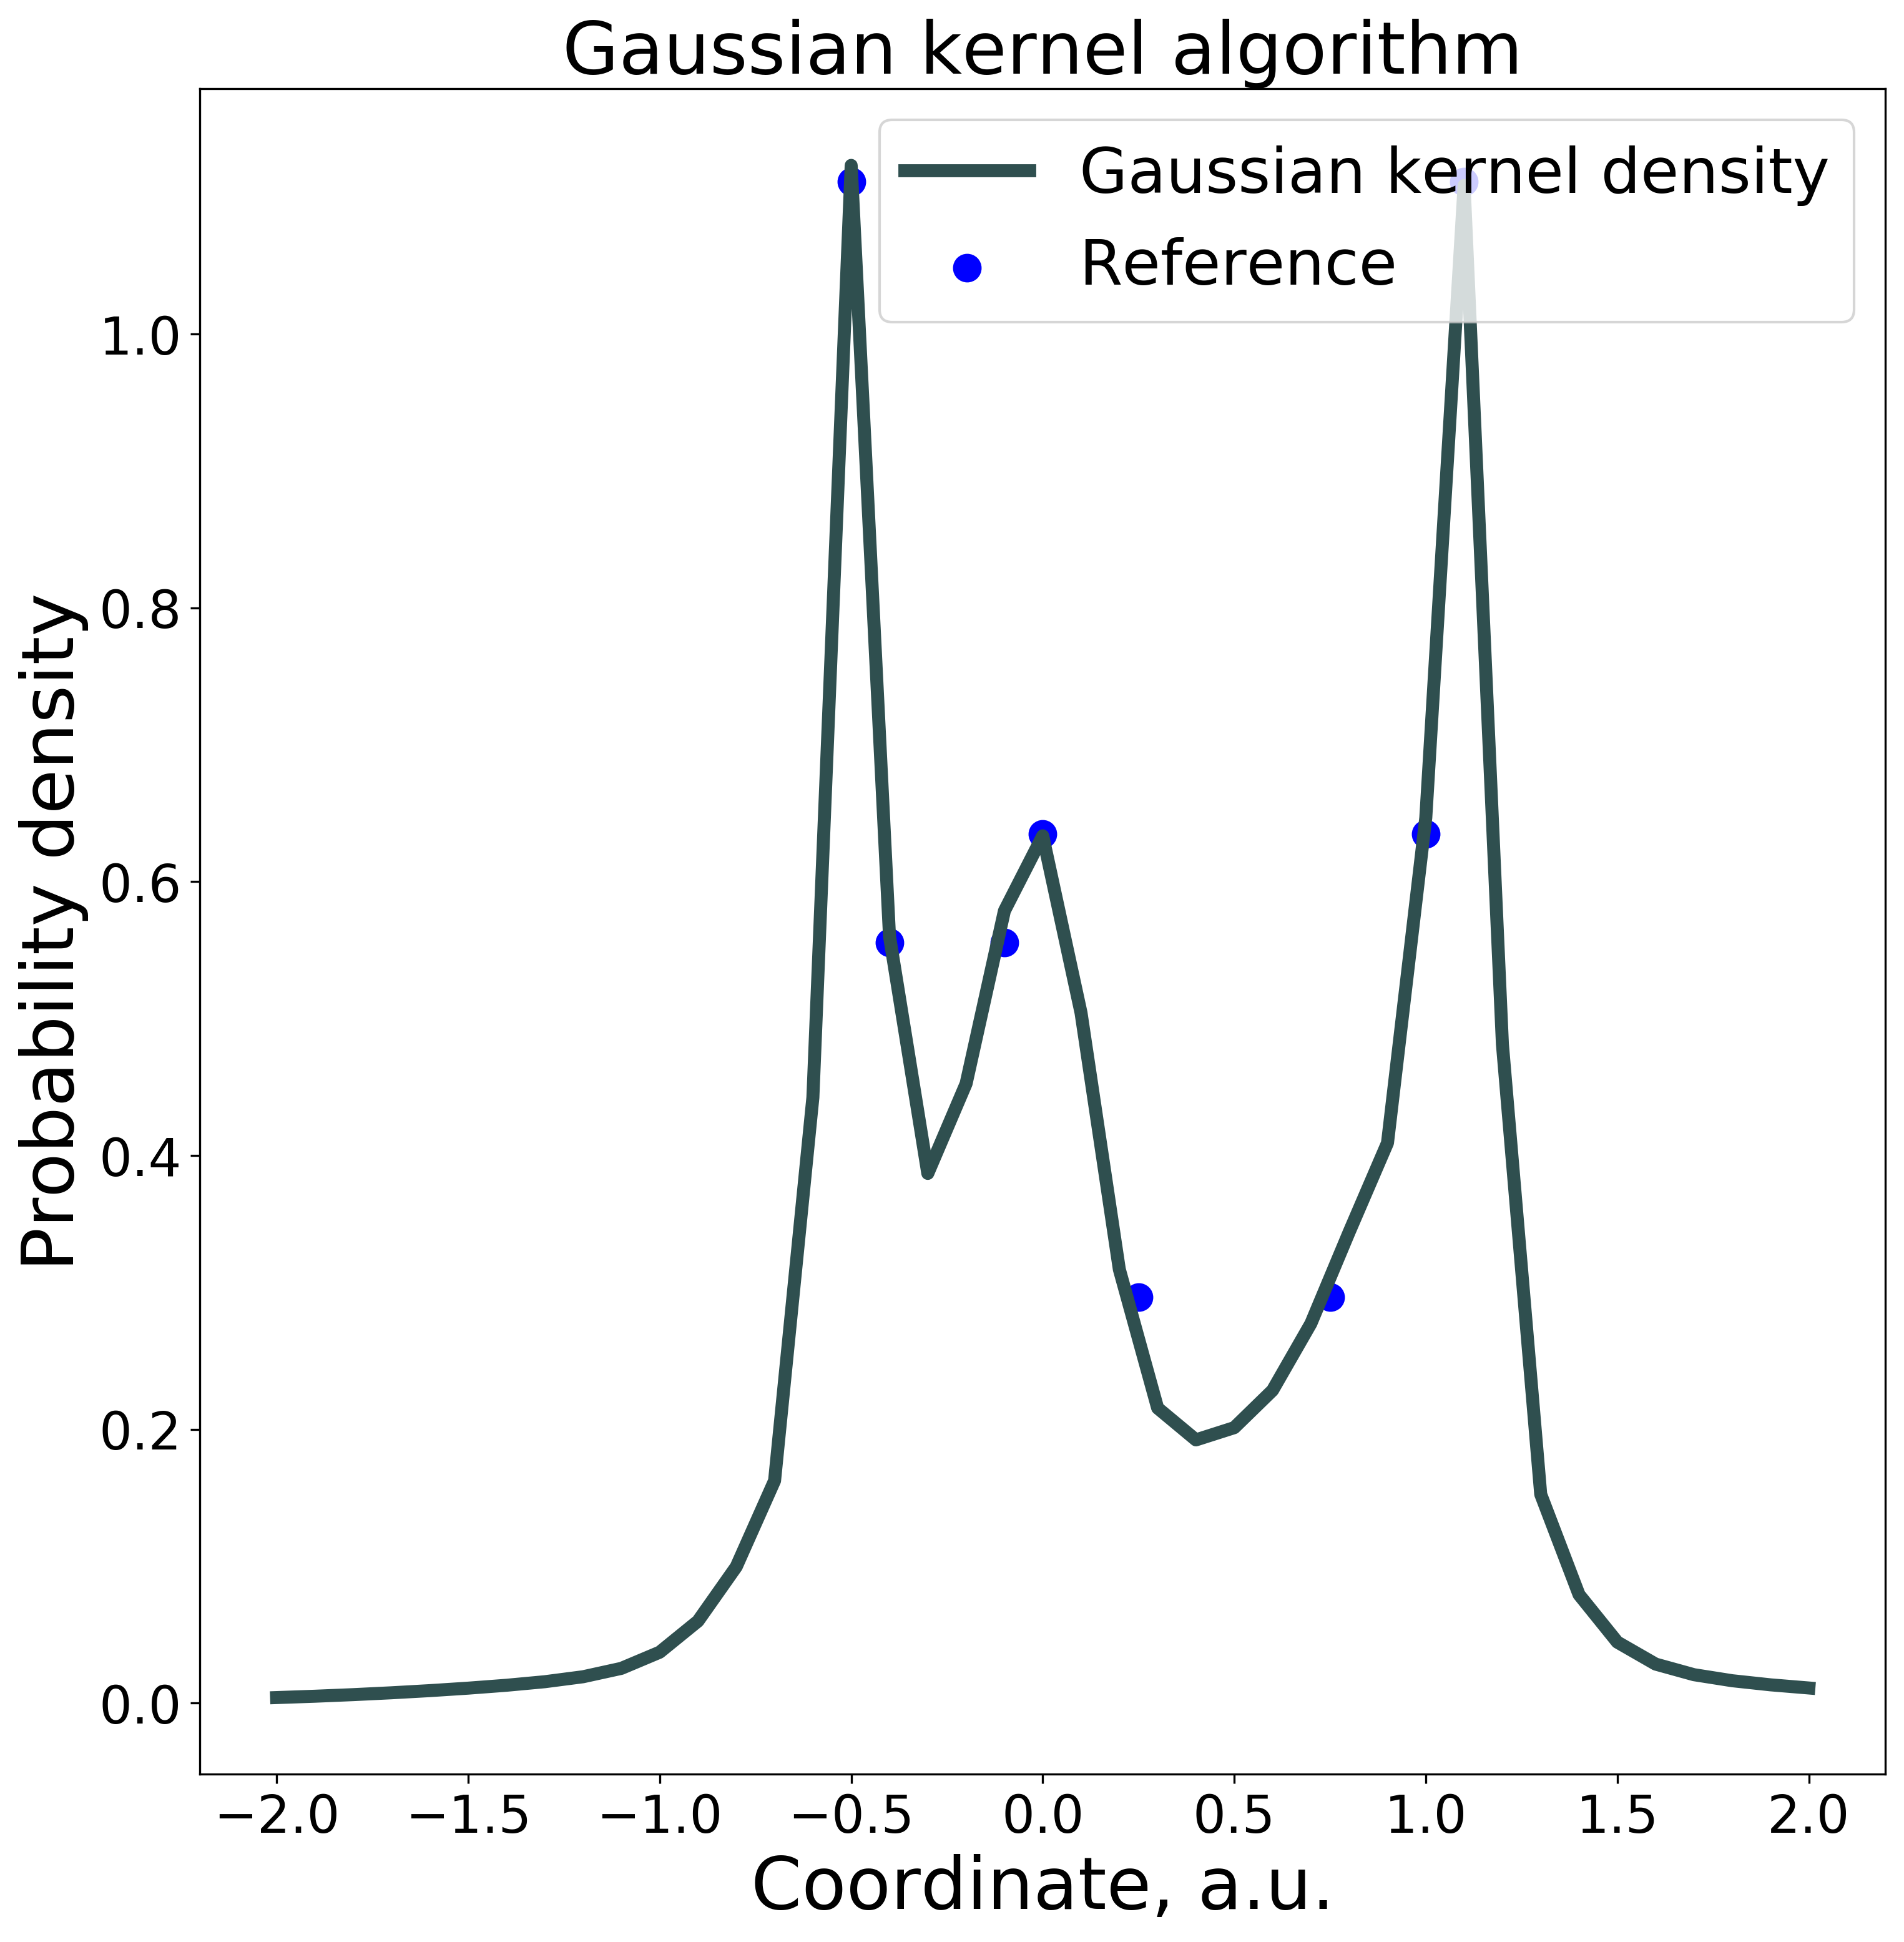

In [10]:
# Our data
Q = [1.0, 0.75, -0.5, 0.25, 0.0, -0.4, 1.1, -0.1]

# Compute the optimized widths
h_new = gka.compute_widths_1D(Q, 10, 1.0)
print(h_new)

# Compute the smooth function on the grid
x_fine = make_grid(-2.0, 2.0, 0.1)
val_new = compute_fitted_prob_densities_1D(x_fine, Q, h_new)

# Compute just for the plotting
target_dens = gka.compute_apriory_prob_densities_1D(Q)

# Plot all the results
plot_my_res(plt, [Q, x_fine], [target_dens, val_new], ["Reference", "Gaussian kernel density"], ["11", "41"])

### 2.4. Example 4: Short workflow, disordered random data
<a name="example4"></a>[Back to TOC](#TOC)

And now, lets just have some fun with more realistic data. We will generate 100 points sampled from the normal distribution with the zero mean and unit variance - this is done with the function `normal()` <a name="normal"></a> of the object of class `Random` defined in Libra <a name="random"></a>

The rest of the snippet is the same as in the above two examples.

**NOTE:** Every time you run this calculations, the data will look different, since it is random.

[0.3566841060166349, 0.015463069581350228, 0.04644770679523824, 0.528018556447437, 0.36987744787940663, 0.1452586823852987, 3198.6294429841982, 0.004605496736624542, 0.0059296653679675616, 0.0077240299953794484, 0.8380736395172363, 0.017985637520350883, 0.01612728687339227, 0.011753688783302551, 0.01438004435977707, 0.036033722641312174, 0.601709507229394, 0.0060899760765345725, 0.1721574850465305, 0.028238293369925553, 805.5926348252299, 0.011189026207278388, 0.01345510181061007, 0.03246828518120598, 0.010338103828066375, 0.02226057024887536, 0.006524453098884927, 0.24068833205732582, 0.007541560430373002, 0.286077661077641, 8.26941614759457, 0.35306129888730237, 0.010590635811474658, 1.0181215915439106, 0.00785452193594682, 0.022613483720087722, 0.028992385301487265, 1.6614116574259317, 0.011227755315282417, 0.026210842368205478, 0.05892014681626562, 0.00698539519273338, 0.058802372883196945, 2.5036560015588707, 0.033305135209315016, 0.5366650057770628, 250.96775917931606, 1.01860650

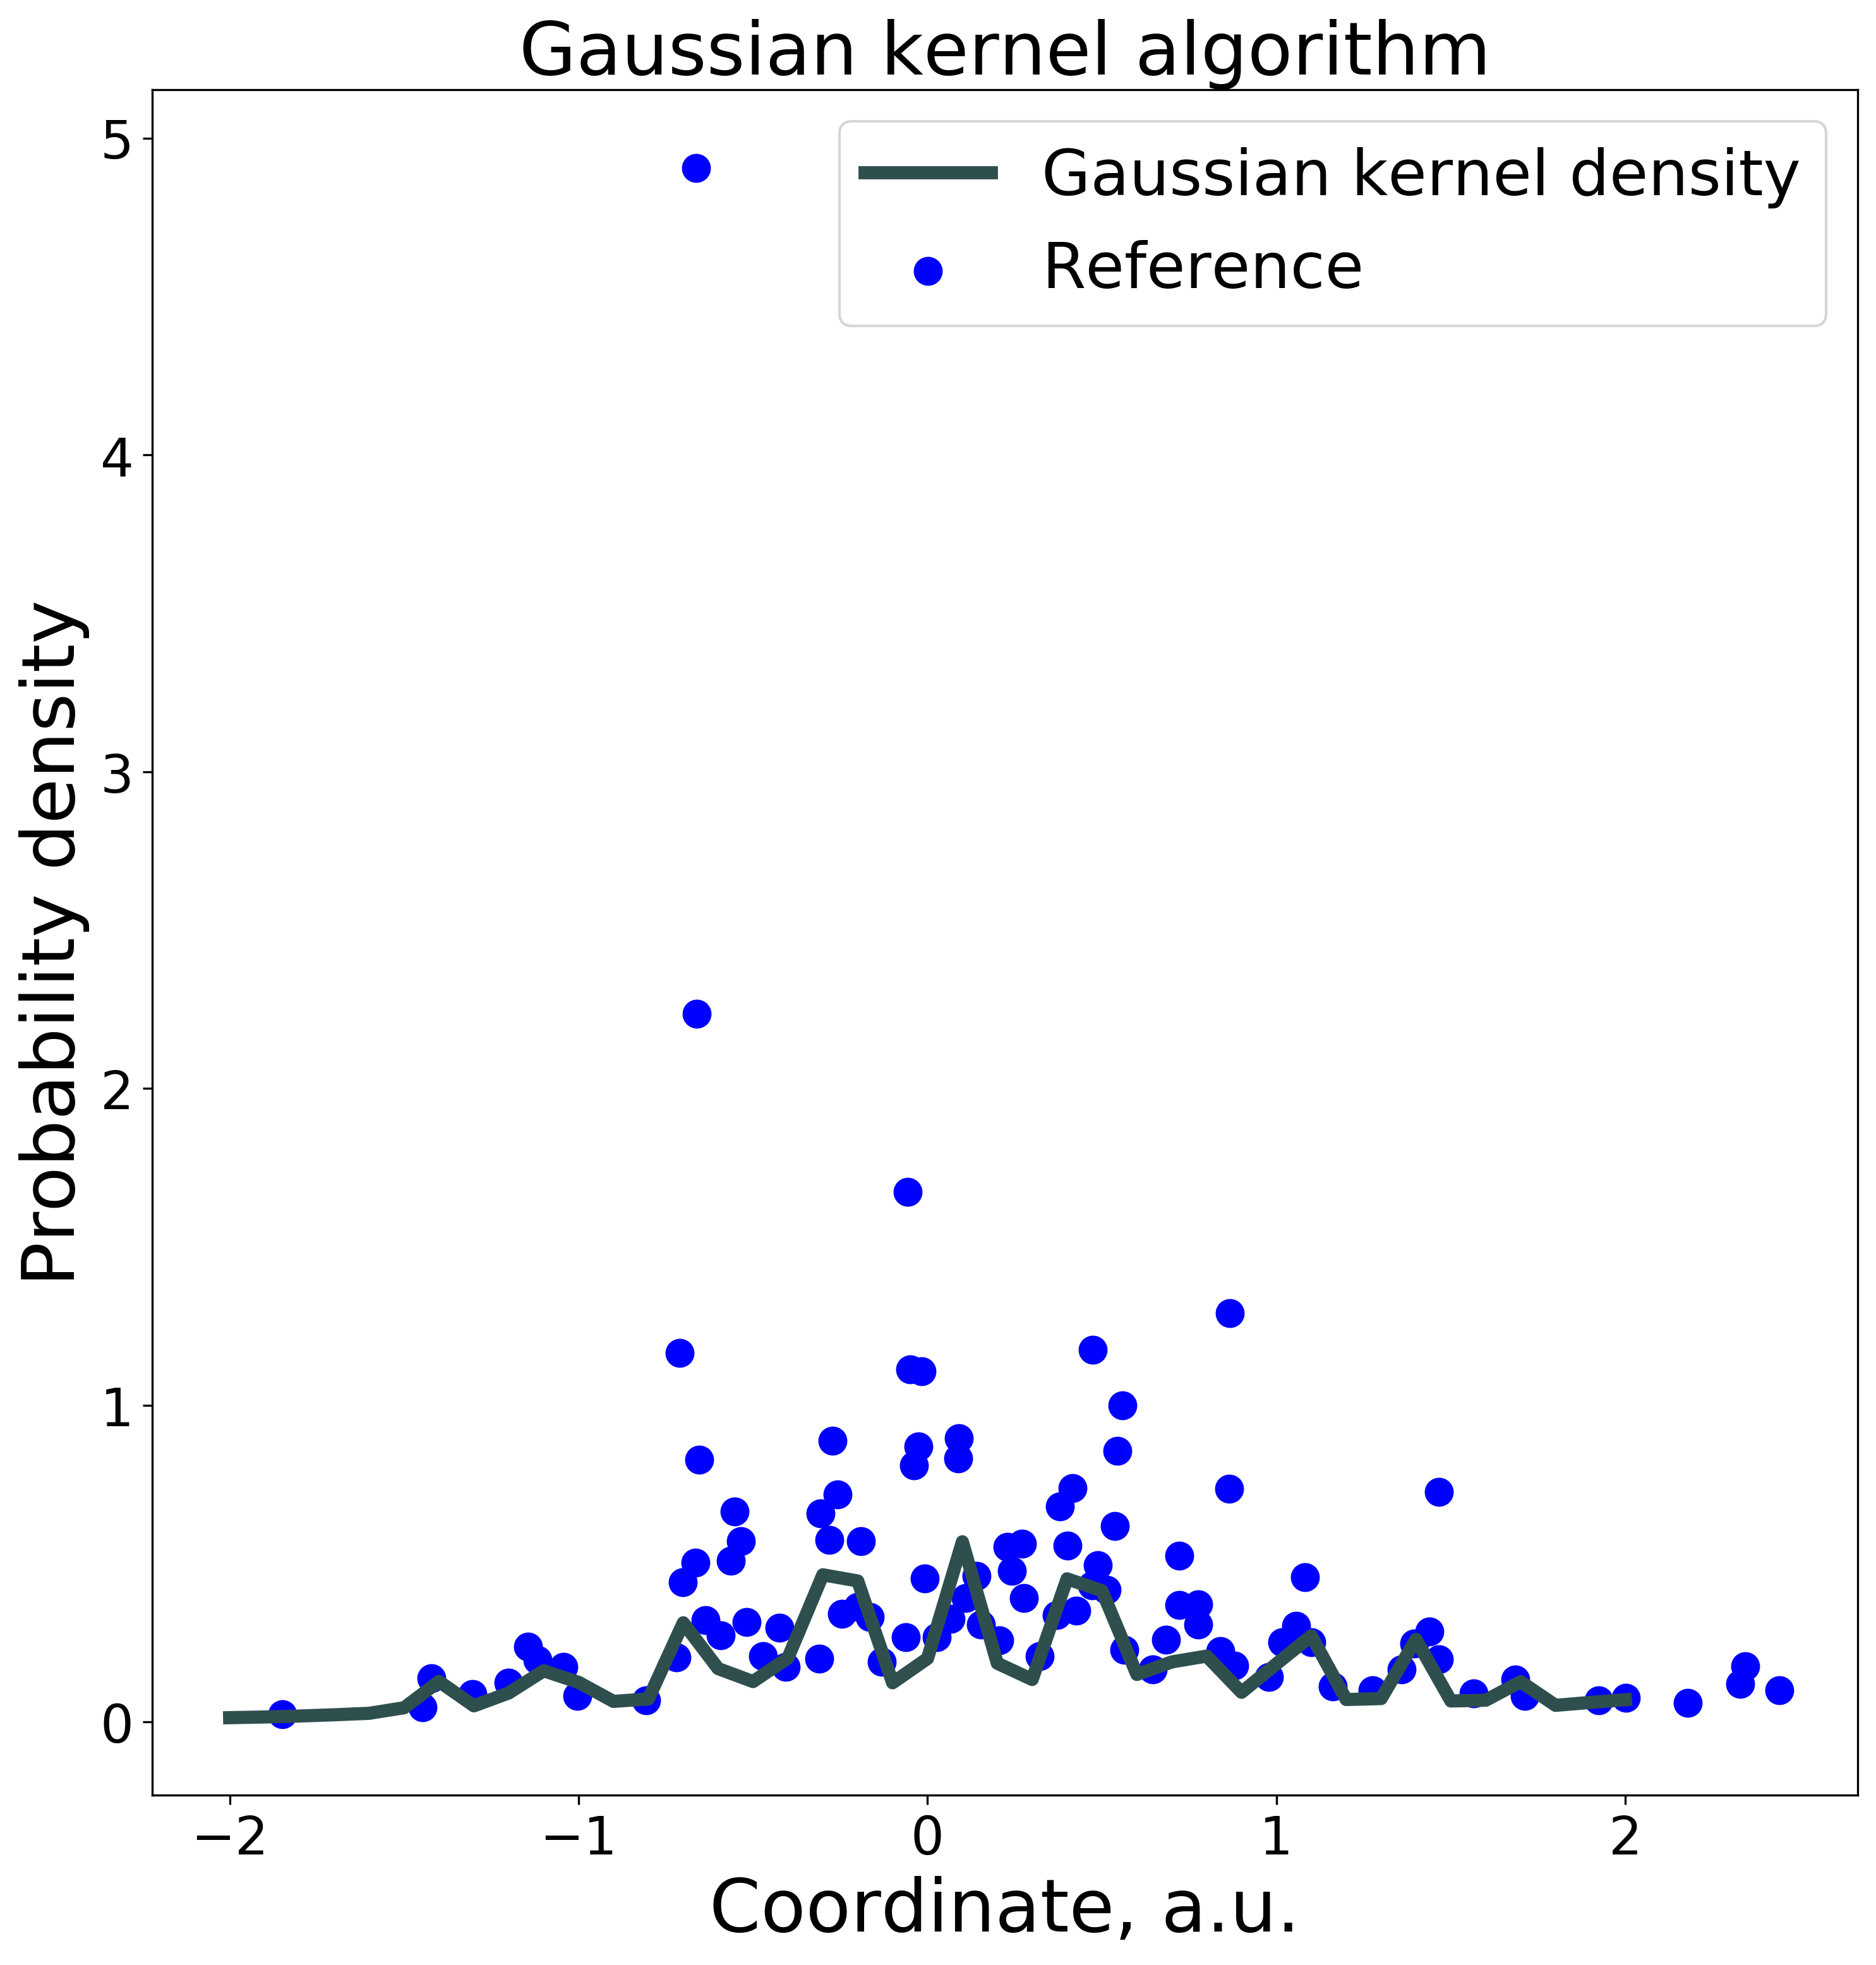

In [11]:
rnd = Random()

Q = []
for i in range(100):    
    Q.append( rnd.normal() )
    
# Compute the optimized widths
h_new = gka.compute_widths_1D(Q, 10, 1.0)
print(h_new)

# Compute the smooth function on the grid
x_fine = make_grid(-2.0, 2.0, 0.1)
val_new = compute_fitted_prob_densities_1D(x_fine, Q, h_new)

# Compute just for the plotting
target_dens = gka.compute_apriory_prob_densities_1D(Q)

# Plot all the results
plot_my_res(plt, [Q, x_fine], [target_dens, val_new], ["Reference", "Gaussian kernel density"], ["11", "41"])